# APPLE GOLDEN DELICIOUS PREDICTION
***

Our task is to predict the average price per apple of APPLE GOLDEN DELICIOUS.

# GETTING STARTED

Importing necessary libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import pickle
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
# get data

train = pd.read_csv('df - train_set.csv')
test = pd.read_csv('df - test_set.csv')

train = train[(train['Commodities'] == 'APPLE GOLDEN DELICIOUS')]
del train['Commodities']
del test['Commodities']

train.head()

,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


## EXPLORATORY DATA ANALYSIS

In [4]:
train.shape

(1952, 12)

In [5]:
test.shape

(685, 12)

In [6]:
test.head()

,Index,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,1,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,2020-07-09,128.0,136.0,5008.0,38,456.0,0
1,2,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,2020-01-20,220.0,220.0,1760.0,8,146.4,2
2,3,W.CAPE-BERGRIVER ETC,EC120,1S,12.0,2020-08-19,120.0,120.0,720.0,6,72.0,45
3,4,W.CAPE-BERGRIVER ETC,M4183,1M,18.3,2020-05-06,160.0,160.0,160.0,1,18.3,8
4,5,W.CAPE-BERGRIVER ETC,M4183,1L,18.3,2020-05-04,140.0,160.0,14140.0,100,1830.0,19


In [7]:
# getting info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          1952 non-null   object 
 1   Container         1952 non-null   object 
 2   Size_Grade        1952 non-null   object 
 3   Weight_Kg         1952 non-null   float64
 4   Date              1952 non-null   object 
 5   Low_Price         1952 non-null   float64
 6   High_Price        1952 non-null   float64
 7   Sales_Total       1952 non-null   float64
 8   Total_Qty_Sold    1952 non-null   int64  
 9   Total_Kg_Sold     1952 non-null   float64
 10  Stock_On_Hand     1952 non-null   int64  
 11  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 198.2+ KB


In [8]:
train['Province'].unique()

array(['CAPE', 'W.CAPE-BERGRIVER ETC', 'EASTERN CAPE', 'NATAL',
       'WEST COAST', 'TRANSVAAL', 'ORANGE FREE STATE'], dtype=object)

In [9]:
train['Container'].unique()

array(['M4183', 'JG110', 'JE090', 'IA400', 'EC120', 'AC030', 'M6125',
       'EF120', 'DT063', 'M9125', 'EG140'], dtype=object)

In [10]:
train['Size_Grade'].unique()

array(['1L', '2M', '2S', '1S', '1M', '1X', '2L', '2U', '2X', '1U'],
      dtype=object)

In [11]:
train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


**Pairplot**

Pairplot  to visualize the relationship between numeric and categorical data.
.

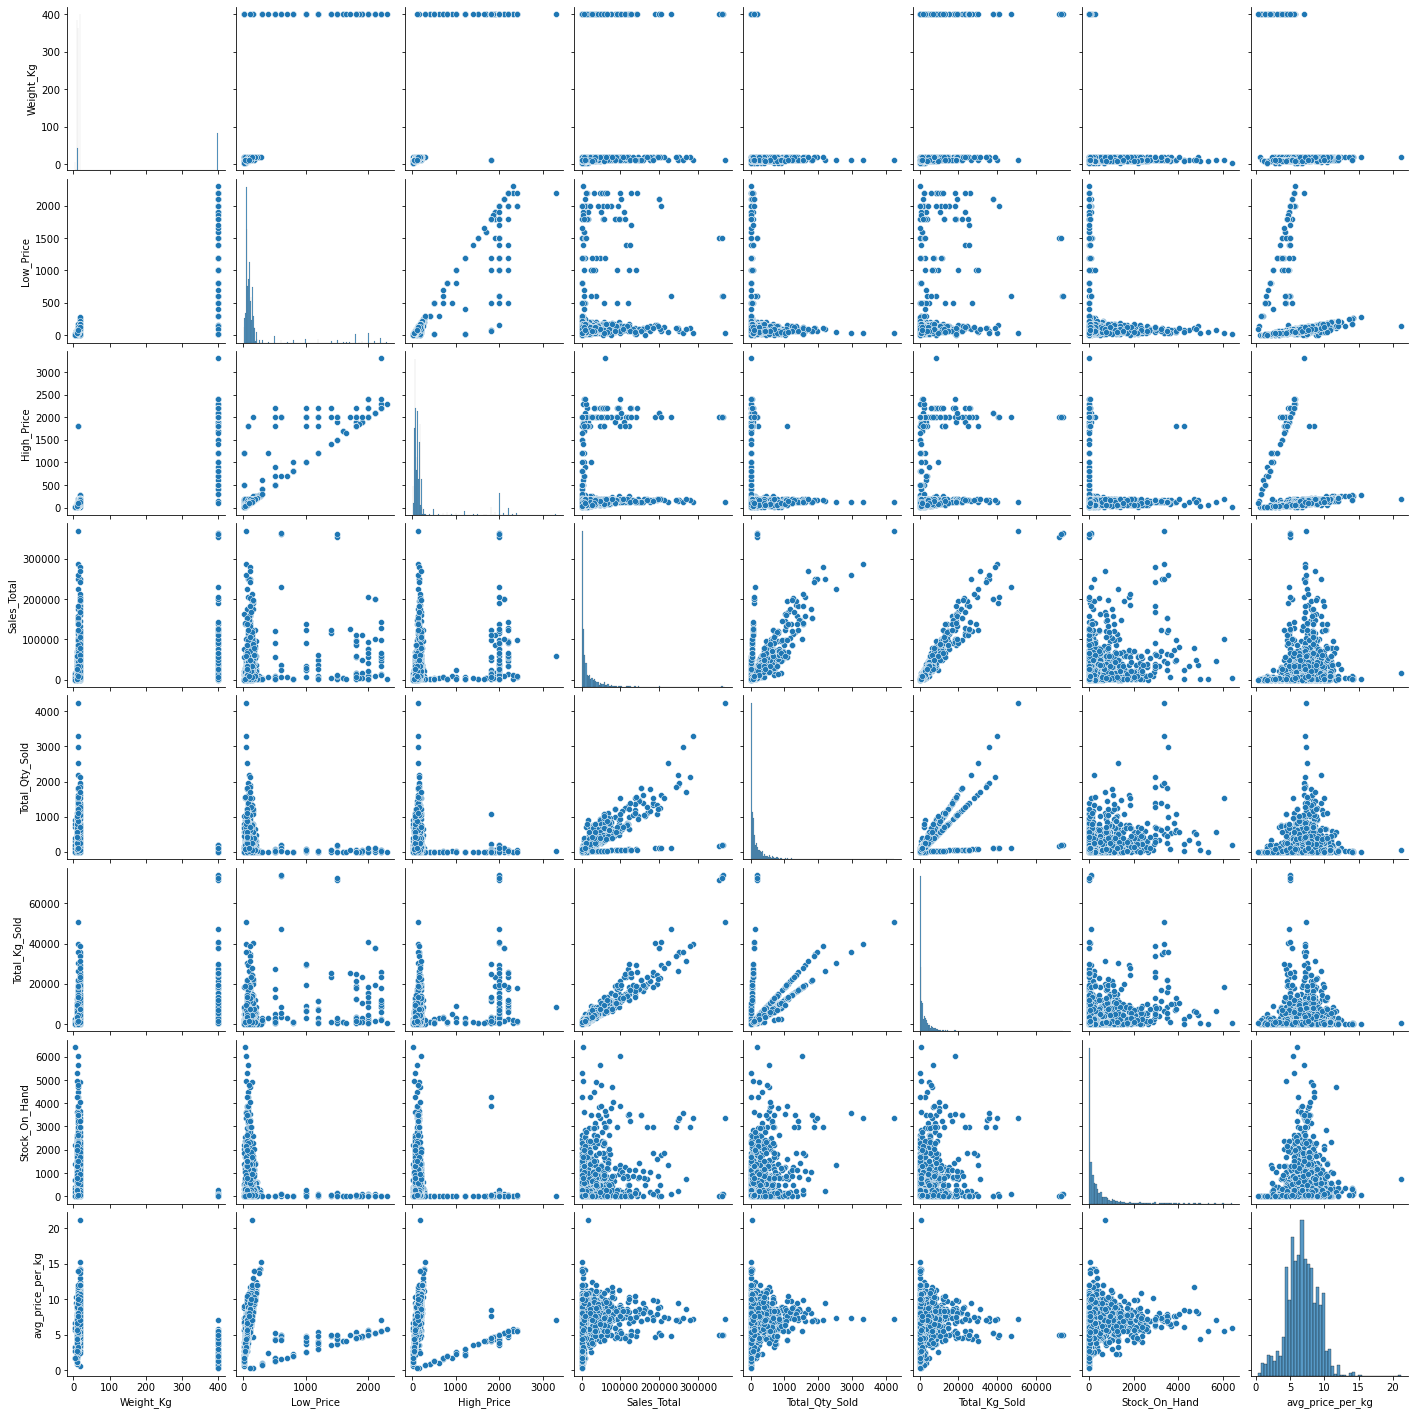

In [12]:
sns.pairplot(train)

**Heatmap**

We used a heatmap to understand correlation between variables.

<AxesSubplot:>

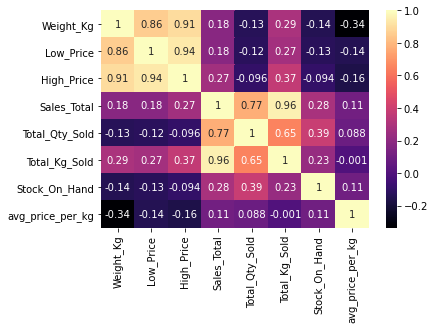

In [13]:
sns.heatmap(train.corr(), annot=True, cmap='magma')

- According to the above correlation matrix Low price, High price, Sales total, Total kg sold, Stock on hand,Total Qty sold, are highly correlated. 
- Highly correlated variables will cause the model to be biased towards them.

**Distribution Plot**

Understanding the distribution of our target 


<AxesSubplot:xlabel='avg_price_per_kg', ylabel='Density'>

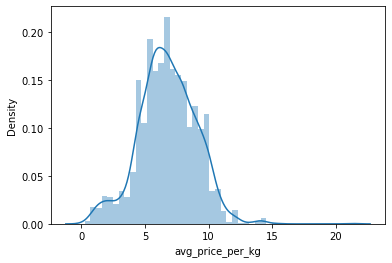

In [14]:
sns.distplot(train['avg_price_per_kg'],kde =True)

The data is normally distributed

Preprocesing Categorical data

In [3]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [4]:
def preprocessing_inputs(df, return_df=False):
    df = df.copy()

    # CLEAN PROVINCE COLUMN

    df['Province'] = df['Province'].str.replace(' ', '_')
    df['Province'] = df['Province'].str.replace('.', '_')
    df['Province'] = df['Province'].str.replace('-', '_')

    # DATE ENCODING
    # Split 'Date' column into year, month and day columns

    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime('%d.%m.%Y')
    df['year'] = pd.DatetimeIndex(df['Date']).year
    df['month'] = pd.DatetimeIndex(df['Date']).month
    df['day'] = pd.DatetimeIndex(df['Date']).day

    df = df.drop(['Date'], axis=1)
    # BINARY ENCODING

    df['year'] = df['year'].replace({2020: 1, 2019: 0})

    # ONE-HOT ENCODING
    for column in ['Province', 'Container']:
        df = onehot_encode(df, column)

    # ORDINAL ENCODING
    df['Size_Grade'] = df['Size_Grade'].replace({
        '1X': 9,
        '1L': 8,
        '1M': 7,
        '1S': 6,
        '1U': 0,
        '2X': 3,
        '2L': 5,
        '2M': 4,
        '2S': 1,
        '2U': 2
    })

    return df

**Lets check for outliers.**

In [5]:
X = preprocessing_inputs(train)

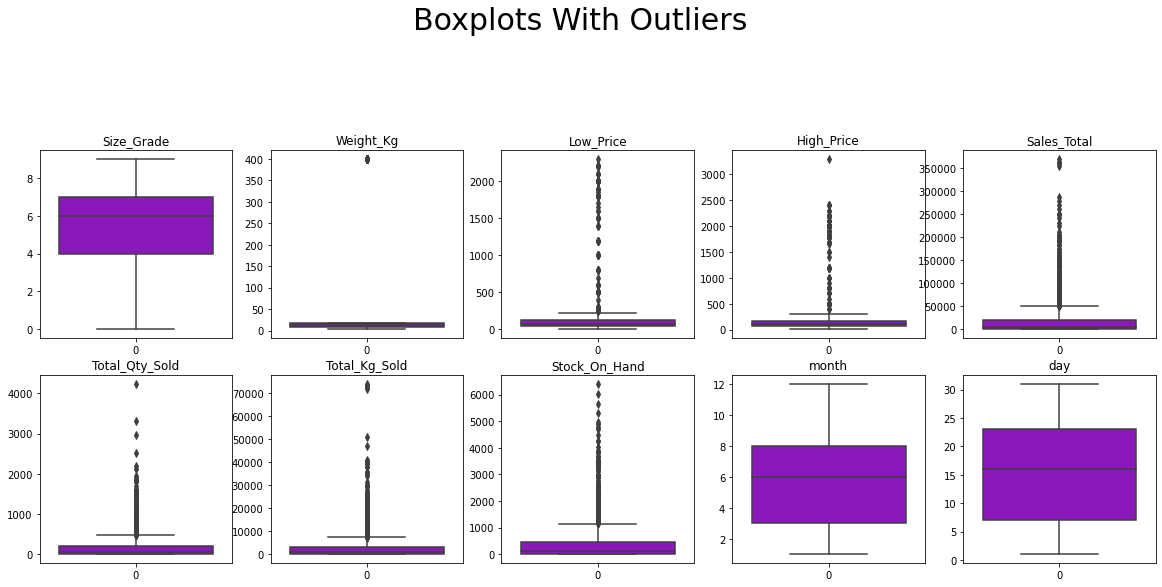

In [18]:
out_df = X.drop('avg_price_per_kg', axis=1).copy()

categorical_columns = [
    column for column in out_df.columns if len(out_df[column].unique()) > 2
]
# Thisisto make sure we dont use categorical data
plt.figure(figsize=(20, 20))

for i, column in enumerate(categorical_columns):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(data=out_df[column].values, color='darkviolet')
    plt.title(column)

plt.suptitle("Boxplots With Outliers", size=30)
plt.show()

- As we can see from the above boxplot the following features (weight kg, low price, high price,sales total, total qty sold,   total kg sold, stock on hand) may have possible outliers.
- We will use Z scores for our analysis
- Any feature that lies outside a z score threshold will be considered an outlier 
- Making the assumption that the variable follows a normal distribution
- The further away it is from 0( i.e mean) the more extreme it is ,the more likely it is to be an outlier

In [5]:
def remove_outliers(df, columns, threshold, asxis=0):
    df = df.copy()
    # Calculate the lower and upper bounds on the Z distribution given a threshold value
    lower_bound = scipy.stats.norm.ppf(q=threshold / 2, loc=0, scale=1)
    upper_bound = scipy.stats.norm.ppf(q=1 - threshold / 2, loc=0, scale=1)

    # Calculate X scores for affected columns
    outlier_df = outlier_df = df.loc[:, columns].copy()
    zscores = pd.DataFrame(scipy.stats.zscore(outlier_df, axis=0),
                           index=outlier_df.index,
                           columns=outlier_df.columns)

    # Get boolean arrays denoting the outlier examples
    lower_outliers = (zscores < lower_bound).any(axis=1)
    upper_outliers = (zscores >= upper_bound).any(axis=1)

    # Get indicies of all outlier examples
    outliers = df[pd.concat([lower_outliers, upper_outliers],
                            axis=1).any(axis=1)].index

    # Drop the outliers
    df = df.drop(outliers, axis=0).reset_index(drop=True)
    #print(len(outliers), "examples dropped.")

    return df

## PREPROCESSING

In [6]:
seed = 1


def preprocess_inputs(df, return_df=False):
    df = df.copy()

    # CLEAN PROVINCE COLUMN

    df['Province'] = df['Province'].str.replace(' ', '_')
    df['Province'] = df['Province'].str.replace('.', '_')
    df['Province'] = df['Province'].str.replace('-', '_')

    # DATE ENCODING
    # Split 'Date' column into year, month and day columns

    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime('%d.%m.%Y')
    df['year'] = pd.DatetimeIndex(df['Date']).year
    df['month'] = pd.DatetimeIndex(df['Date']).month
    df['day'] = pd.DatetimeIndex(df['Date']).day

    df = df.drop(['Date'], axis=1)

    # BINARY ENCODING

    df['year'] = df['year'].replace({2020: 1, 2019: 0})

    # ONE-HOT ENCODING
    for column in ['Province', 'Container']:
        df = onehot_encode(df, column)

    # ORDINAL ENCODING
    enc = OrdinalEncoder()
    df[['Size_Grade']] = enc.fit_transform(df[['Size_Grade']])

    # REMOVE OUTLIERS from Train set
    if 'avg_price_per_kg' in df.columns:

        df = remove_outliers(df=df,
                             columns=[
                                 'Weight_Kg', 'Low_Price', 'High_Price',
                                 'Sales_Total', 'Total_Qty_Sold',
                                 'Total_Kg_Sold', 'Stock_On_Hand'
                             ],
                             threshold=0.0000000000001)

    if return_df == True:
        ## for training dataset
        # REORDER COLUMNS SO THAT OUR DEPENDENT VARIABLE IS THE LAST COLUMN OF THE DATAFRAME
        if 'avg_price_per_kg' in df.columns:
            column_titles = [
                col for col in df.columns if col != 'avg_price_per_kg'
            ] + ['avg_price_per_kg']
            df = df.reindex(columns=column_titles)

        return df

    ## for training dataset
    # REORDER COLUMNS SO THAT OUR DEPENDENT VARIABLE IS THE LAST COLUMN OF THE DATAFRAME
    elif 'avg_price_per_kg' in df.columns:
        column_titles = [
            col for col in df.columns if col != 'avg_price_per_kg'
        ] + ['avg_price_per_kg']
        df = df.reindex(columns=column_titles)

        # SPLIT DATA INTO PREDICTORS AND TARGET

        y = df['avg_price_per_kg']
        X = df.drop('avg_price_per_kg', axis=1)
        y = np.array(y)
        
        # TRAIN TEST SPLIT
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.35,
                                                            shuffle=False,
                                                            random_state=seed)

        return X_train, X_test, y_train, y_test

    else:
        return df

## DATA MODELING

**Data Splitting**

In [16]:
X_train, X_test, y_train, y_test = preprocess_inputs(train)

**Model Training**

In [11]:
# Models to be trained

models = {
    "                         Decision Tree": DecisionTreeRegressor(random_state= seed),
    "                         Random Forest": RandomForestRegressor(random_state= seed),
    "                     Gradient Boosting": GradientBoostingRegressor(learning_rate=0.18, n_estimators=6000, 
                                                                        random_state= seed, max_depth =2),
    "                               XGBoost": XGBRegressor(max_depth=2,min_child_weight=13,subsample=1,colsample_bytree=1,
            objective='reg:squarederror',n_estimators=6000, learning_rate=0.3, random_state= seed),
    "                     CatBoostRegressor": CatBoostRegressor(verbose= 0, learning_rate=0.09, depth = 4),
    "                         LGBMRegressor": LGBMRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                         Decision Tree trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
                     CatBoostRegressor trained.
                         LGBMRegressor trained.


In [17]:
#EVALUATE MODEL ON R SQUARED - HIGHER IS BETTER

for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(X_test, y_test)))
    

                         Decision Tree R^2 Score: 0.91932
                         Random Forest R^2 Score: 0.94942
                     Gradient Boosting R^2 Score: 0.95578
                               XGBoost R^2 Score: 0.96955
                     CatBoostRegressor R^2 Score: 0.94935
                         LGBMRegressor R^2 Score: 0.94596


In [18]:
#EVALUATE MODEL ON RMSE, MAE, MAPE 

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(name + " Test RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_test ,y_pred))))
    
    y_train_pred = model.predict(X_train)
    print(name + " Train RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_train_pred ,y_train))))
    
    errors = abs(y_pred - y_test) 
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'Rand.') # Mean absolute error

    mape = np.mean(100 * (errors / y_test)) 
    accuracy = 100 - mape

    print('Accuracy:', round(accuracy, 2), '%.') # Mean absolute percentage error

                         Decision Tree Test RMSE: 0.65040
                         Decision Tree Train RMSE: 0.00000
Mean Absolute Error: 0.33 Rand.
Accuracy: 94.25 %.
                         Random Forest Test RMSE: 0.51496
                         Random Forest Train RMSE: 0.24545
Mean Absolute Error: 0.3 Rand.
Accuracy: 94.21 %.
                     Gradient Boosting Test RMSE: 0.48152
                     Gradient Boosting Train RMSE: 0.02295
Mean Absolute Error: 0.29 Rand.
Accuracy: 95.21 %.
                               XGBoost Test RMSE: 0.39957
                               XGBoost Train RMSE: 0.02994
Mean Absolute Error: 0.26 Rand.
Accuracy: 94.89 %.
                     CatBoostRegressor Test RMSE: 0.51533
                     CatBoostRegressor Train RMSE: 0.16817
Mean Absolute Error: 0.31 Rand.
Accuracy: 93.28 %.
                         LGBMRegressor Test RMSE: 0.53228
                         LGBMRegressor Train RMSE: 0.31545
Mean Absolute Error: 0.33 Rand.
Accuracy: 93

# FEATURE SELECTION

In [19]:
# FEAUTURE IMPORTANCES

df = train.drop('avg_price_per_kg', axis = 1)
features = preprocess_inputs(df)
feature_list = list(features.columns)


for name, model in models.items():
    if name == "                               XGBoost":
        # Get numerical feature importances
        importances = list(model.feature_importances_)

        # List of tuples with variable and importance
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

        # Sort the feature importances by most important first
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

        # Print out the feature and importances 
        [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];



Variable: Weight_Kg            Importance: 0.550000011920929
Variable: Low_Price            Importance: 0.11999999731779099
Variable: Container_JG110      Importance: 0.07999999821186066
Variable: High_Price           Importance: 0.07000000029802322
Variable: Province_NATAL       Importance: 0.05999999865889549
Variable: year                 Importance: 0.029999999329447746
Variable: Province_W_CAPE_BERGRIVER_ETC Importance: 0.029999999329447746
Variable: Container_M4183      Importance: 0.019999999552965164
Variable: Sales_Total          Importance: 0.009999999776482582
Variable: Province_EASTERN_CAPE Importance: 0.009999999776482582
Variable: Container_EC120      Importance: 0.009999999776482582
Variable: Size_Grade           Importance: 0.0
Variable: Total_Qty_Sold       Importance: 0.0
Variable: Total_Kg_Sold        Importance: 0.0
Variable: Stock_On_Hand        Importance: 0.0
Variable: month                Importance: 0.0
Variable: day                  Importance: 0.0
Variable: P

In [12]:
#SELECTING IMPORTANT FEATURES

df = preprocess_inputs(train, return_df=True)


y = df['avg_price_per_kg']
X = df.drop('avg_price_per_kg', axis=1)

# GET IMPORTANT COLUMN NAMES

important = []
for i in [ 'Total_Kg_Sold', 'Container_IA400', 'Container_M4183', "Container_JE090", 'Container_JG110', 
          'Weight_Kg', 'Total_Qty_Sold', 'High_Price', 'Sales_Total', 'Stock_On_Hand']:
    A = [col for col in df.columns if i in col]
    important.append(A)
    
important_list = [item for sublist in important for item in sublist]

# IMPORTANT DATAFRAME

X_imp = X[important_list]
print(important_list)


['Total_Kg_Sold', 'Container_IA400', 'Container_M4183', 'Container_JE090', 'Container_JG110', 'Weight_Kg', 'Total_Qty_Sold', 'High_Price', 'Sales_Total', 'Stock_On_Hand']


In [29]:
# TEST NEW MODEL WITH IMPORTANT FEATURES ONLY

X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.35, shuffle=False, random_state=seed)

xgb = XGBRegressor(max_depth=2,min_child_weight=13,subsample=1,colsample_bytree=1,
            objective='reg:squarederror',n_estimators=6000, learning_rate=0.3, random_state= seed)
xgb.fit(X_imp_train, y_train)
print("Trained.")

Trained.


In [30]:
# CHECK PERFORMANCE METRICS

pred = xgb.predict(X_imp_test)

errors = abs(pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'rand.')

mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')
print("Test RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_test ,pred))))
y_train_pred = xgb.predict(X_imp_train)
print("Train RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_train_pred ,y_train))))

Mean Absolute Error: 0.23 rand.
Accuracy: 95.79 %.
Test RMSE: 0.35301
Train RMSE: 0.05385


Lets compare all the models with their previous score.

In [17]:
# TRAIN MODELS AGAIN BUT WITH THE SUBSET CREATED ABOVE

X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.35, shuffle=False, random_state=seed)
# TRAIN A FEW MODELS

models = {
    "                         Decision Tree": DecisionTreeRegressor(random_state= seed),
    "                         Random Forest": RandomForestRegressor(random_state= seed),
    "                     Gradient Boosting": GradientBoostingRegressor(learning_rate=0.18, n_estimators=6000,
                                                                        random_state= seed, max_depth =2),
    "                               XGBoost": XGBRegressor(max_depth=2,min_child_weight=13,subsample=1,colsample_bytree=1,
            objective='reg:squarederror',n_estimators=6000, learning_rate=0.3, random_state= seed),
    "                     CatBoostRegressor": CatBoostRegressor(verbose=0, learning_rate=0.09),
    "                         LGBMRegressor": LGBMRegressor()
}

for name, model in models.items():
    model.fit(X_imp_train, y_train)
    print(name + " trained.")

                         Decision Tree trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
                     CatBoostRegressor trained.
                         LGBMRegressor trained.


In [15]:
#EVALUATE SQUARED - HIGHER IS BETTER

for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(X_imp_test, y_test)))
 

                         Decision Tree R^2 Score: 0.85555
                         Random Forest R^2 Score: 0.90380
                     Gradient Boosting R^2 Score: 0.96998
                               XGBoost R^2 Score: 0.97623
                     CatBoostRegressor R^2 Score: 0.94966
                         LGBMRegressor R^2 Score: 0.92993


In [18]:
#EVALUATE MODEL ON RMSE, MAE, MAPE

X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.35, shuffle=False, random_state=seed)
 

for name, model in models.items():
    y_pred = model.predict(X_imp_test)
    print(name + " Test RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_test ,y_pred))))
    
    y_train_pred = model.predict(X_imp_train)
    print(name + " Train RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_train_pred ,y_train))))
    
    errors = abs(y_pred - y_test) 
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'Rand.') # Mean absolute error

    mape = np.mean(100 * (errors / y_test)) 
    accuracy = 100 - mape

    print('Accuracy:', round(accuracy, 2), '%.') # Mean absolute percentage error

                         Decision Tree Test RMSE: 0.87025
                         Decision Tree Train RMSE: 0.00000
Mean Absolute Error: 0.52 Rand.
Accuracy: 91.5 %.
                         Random Forest Test RMSE: 0.71021
                         Random Forest Train RMSE: 0.28892
Mean Absolute Error: 0.46 Rand.
Accuracy: 91.82 %.
                     Gradient Boosting Test RMSE: 0.39671
                     Gradient Boosting Train RMSE: 0.03676
Mean Absolute Error: 0.26 Rand.
Accuracy: 95.58 %.
                               XGBoost Test RMSE: 0.35301
                               XGBoost Train RMSE: 0.05385
Mean Absolute Error: 0.23 Rand.
Accuracy: 95.79 %.
                     CatBoostRegressor Test RMSE: 0.51372
                     CatBoostRegressor Train RMSE: 0.12938
Mean Absolute Error: 0.33 Rand.
Accuracy: 93.08 %.
                         LGBMRegressor Test RMSE: 0.60610
                         LGBMRegressor Train RMSE: 0.36579
Mean Absolute Error: 0.4 Rand.
Accuracy: 92.

It apears the majority of the best performing models from our initial training have improved. Lets improve them a bit more.

## Ensemble Stacking

In [19]:
# NOW ENSEMBLE STACKING

# CHOOSE BEST MODELS FROM EARLIER SCORES

gb = GradientBoostingRegressor(learning_rate=0.18, n_estimators=6000, random_state= seed, max_depth =2)
xgb = XGBRegressor(max_depth=2,min_child_weight=13,subsample=1,colsample_bytree=1,
            objective='reg:squarederror',n_estimators=6000, learning_rate=0.3, random_state= seed)
meta_learner_reg =  XGBRegressor(max_depth=2,min_child_weight=13,subsample=1,colsample_bytree=1, 
                                 objective='reg:squarederror', n_estimators=6000, learning_rate=0.3, random_state= seed)

models_4stacking = [("gb", gb),("xgb", xgb)]

s_reg = StackingRegressor(estimators=models_4stacking, final_estimator= meta_learner_reg, passthrough = True, cv= 4)


In [36]:
# TRAIN ON DATAFRAME WITH 7 COLUMNS(MOST IMPORTANT)

X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.35, shuffle=False, random_state=seed)

s_reg.fit(X_imp_train,y_train)
print("Stacked model fitted.")

Stacked model fitted.


In [37]:
X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.35, shuffle=False, random_state=seed)

In [38]:
# METRICS OF STACKING REGRESSOR

y_pred = s_reg.predict(X_imp_test)
rsq = s_reg.score(X_imp_test, y_test)
print("R^2 Score: ", rsq)

print("Test RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_test ,y_pred))))

y_train_pred = model.predict(X_imp_train)
print("Train RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_train_pred ,y_train))))
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Rand.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

R^2 Score:  0.9725966094670113
Test RMSE: 0.37905
Train RMSE: 0.36579
Mean Absolute Error: 0.26 Rand.
Accuracy: 95.84 %.


## Cross Validation

### Perfoming Kfold Split 


We will perform a Kfold cross validation using the stacking regressor model defined above, which will leave us with 
the best stacking regression model.

In [39]:
df = preprocess_inputs(train, return_df=True)

y = df['avg_price_per_kg']
X = df.drop('avg_price_per_kg', axis=1)

important = []
for i in [ 'Total_Kg_Sold', 'Container_IA400', 'Container_M4183', "Container_JE090", 'Container_JG110', 
          'Weight_Kg', 'Total_Qty_Sold', 'High_Price', 'Sales_Total', 'Stock_On_Hand']:
    A = [col for col in df.columns if i in col]
    important.append(A)
    
important_list = [item for sublist in important for item in sublist]

# IMPORTANT DATAFRAME
X_imp = X[important_list]

def split_data_kf(df,K):
    
    y = df['avg_price_per_kg']
    X = df[important_list]  # SUBSET FOR IMPORTANT ROWS
    
    kf = KFold(n_splits=K, shuffle = False)
    indices = []
    
    for train_index, test_index in kf.split(X):
        indices.append((train_index, test_index))
        
    return indices


def get_best_kfmodel(df,data_indices):
    y = df['avg_price_per_kg']
    X = df[important_list]
    
    RMSE = []
    trainRMSE =[]
    
    for (train_indices,test_indices) in data_indices:
        X_train, y_train = X.iloc[train_indices,:],y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices,:], y.iloc[test_indices]
        
        model = StackingRegressor(estimators=models_4stacking, final_estimator= meta_learner_reg, passthrough = True, cv= 4)
        
        model.fit(X_train.values, y_train.values) 

        y_pred = model.predict(X_test.values)     
        
        rmse = np.sqrt(metrics.mean_squared_error(y_test.values ,y_pred))
        RMSE.append(rmse)
        
        y_train_pred = model.predict(X_train.values)
        
        train_rsme = np.sqrt(metrics.mean_squared_error( y_train.values,y_train_pred))
        trainRMSE.append(train_rsme)
        
    best = RMSE.index(min(RMSE))
    best_indicies = data_indices[best]
    
    
    X_train, y_train = X.iloc[best_indicies[0],:],y.iloc[best_indicies[0]]
    X_test, y_test = X.iloc[best_indicies[1],:], y.iloc[best_indicies[1]]
    
    model = StackingRegressor(estimators=models_4stacking, final_estimator= meta_learner_reg, passthrough = True, cv= 4)
    
    model.fit(X_train.values, y_train.values)       
          
    return model


    
# GET THE KFOLD SPLIT ON WHICH THE MODEL WAS TRAINED
def get_best_split(df,data_indices, model):
    y = df['avg_price_per_kg']
    X = df[important_list]
    
    RMSE = []
    trainRMSE =[]
    
    for (train_indices,test_indices) in data_indices:
        X_train, y_train = X.iloc[train_indices,:],y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices,:], y.iloc[test_indices]

        y_pred = model.predict(X_test.values)     
        
        rmse = np.sqrt(metrics.mean_squared_error(y_test.values ,y_pred))
        RMSE.append(rmse)
        
        y_train_pred = model.predict(X_train.values)
        
        train_rsme = np.sqrt(metrics.mean_squared_error( y_train.values,y_train_pred))
        trainRMSE.append(train_rsme)
        
    best = RMSE.index(min(RMSE))
    best_indicies = data_indices[best]
    
    X_train, y_train = X.iloc[best_indicies[0],:],y.iloc[best_indicies[0]]
    X_test, y_test = X.iloc[best_indicies[1],:], y.iloc[best_indicies[1]]
          
    return X_train.values, X_test.values, y_train.values, y_test.values
              

**Lets find our best model**

In [ ]:
train_df = preprocess_inputs(train, return_df = True)
data_indices = split_data_kf(train_df,4)
model = get_best_kfmodel(train_df,data_indices)

print('Best Stacking Regressor Trained.')

**Saving the model**

In [ ]:
# #Pickling

model_save_path = "assets/trained-models/stacked_kfold.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)


**Restoring the model**

In [8]:
# Unpickle the model

model_load_path = "assets/trained-models/stacked_kfold.pkl"
with open(model_load_path,'rb') as file:
    unpickled_model = pickle.load(file)



**Metric Check**

In [42]:
# GET METRICS OF THE BEST STACKING REGRESSOR MODEL FROM KFOLD SPLIT

df = preprocess_inputs(train, return_df = True)
data_indices = split_data_kf(df,4)

X_train, X_test, y_train, y_test = get_best_split(df, data_indices, unpickled_model)
s_reg = unpickled_model 

y_pred = s_reg.predict(X_test)
rsq = s_reg.score(X_test, y_test)
print("R^2 Score: ", rsq)

print("Test RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_test ,y_pred))))

y_train_pred = s_reg.predict(X_train)
print("Train RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_train_pred ,y_train))))
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Rand.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

R^2 Score:  0.9857074714310848
Test RMSE: 0.26489
Train RMSE: 0.29704
Mean Absolute Error: 0.18 Rand.
Accuracy: 97.29 %.


**Predict on unseen data and save to csv for Kaggle**

In [20]:
# Predict with best model
df = preprocess_inputs(test)
Xs = list(df.columns)
Xs.remove('Index')

X_test = df[Xs]

important_list = ['Total_Kg_Sold', 'Container_IA400', 'Container_M4183', 'Container_JE090', 
 'Container_JG110', 'Weight_Kg', 'Total_Qty_Sold', 'High_Price', 'Sales_Total', 'Stock_On_Hand']

X_Test_imp = X_test[important_list]

y_pred = unpickled_model.predict(X_Test_imp.values) # Predict with best model
d = pd.DataFrame(y_pred, columns =['avg_price_per_kg'])
dff = pd.concat([df['Index'], d], axis=1)
dff = dff.set_index('Index')
dff.to_csv('stackedkfold.csv')


**View Kaggle Prediction data**

In [21]:
predictions = pd.read_csv('stackedkfold.csv')
predictions.head(10)

,Index,avg_price_per_kg
0,1,10.977670
1,2,13.055924
2,3,9.959006
3,4,9.027147
4,5,8.134614
5,6,4.607167
6,7,3.337298
7,8,8.252940
8,9,8.009070
9,10,9.349796


## Assessing Model Accuracy

We will now be assing the accuracy of our models by creating a few predicted against actual Y plots.

Ideally, for a good fit, all the points should be close to the regressed diagonal line, the line plotted from the y-test values on both x and y axes.

If the model had a low Root Mean Squared Error, all the points would be close to this diagonal line. The higher the RMSE, the weaker the Goodness of fit of the model, the more foggy or dispersed the points are (away from this diagonal line).

 
With the first plot we will assess the accuracy of our Stacking Regressor. The second plot, we'll assess the Gradient Boosting Regressor, which is on of the estimators of our Stacking Regressor. The third plot will be the XGBooster Regressor. The XGB regressor is also an estimator of our Stacking Regressor, but aso the final estimator of it. We will see why in the plots below.

**Stacking Regressor of Gradient Boosting and XGBooster Regressor**

Text(0.5, 1.0, 'Predicted vs Actual\n                 Stacking Regressor of                  \n Gradient Boosting and XGBooster Regressor\n \ntest RMSE = 0.2907 \n train RMSE = 0.28861 \nR^2 Score = 0.98388 \nMAE = 0.18 \nAccuracy = 97.21')

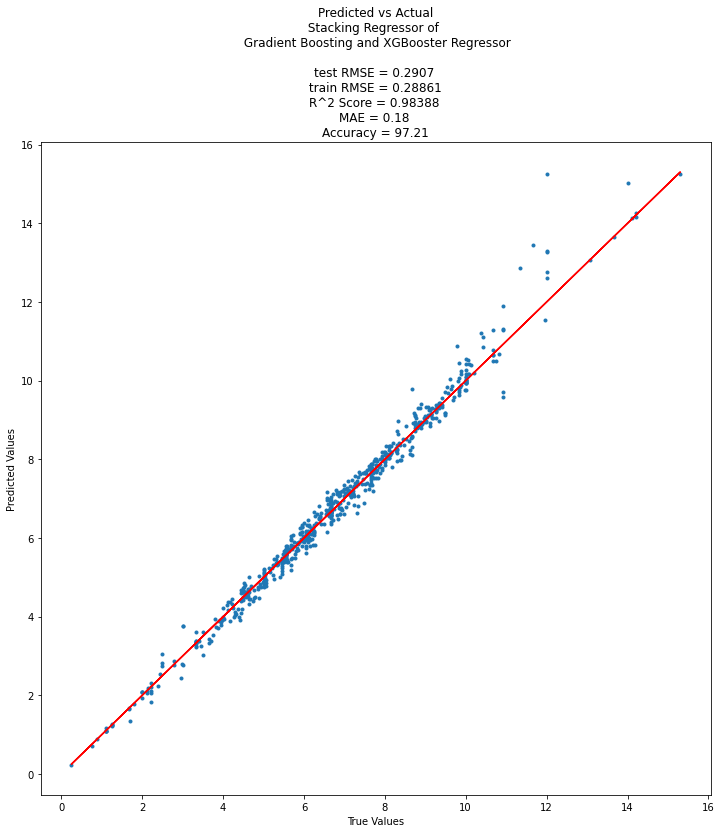

In [25]:
# Assess model accuracy with plot of the predicted y values against the actual y values from train test split

df = preprocess_inputs(train, return_df=True)
y = df['avg_price_per_kg']
X = df.drop('avg_price_per_kg', axis=1)
important_list = ['Total_Kg_Sold', 'Container_IA400', 'Container_M4183', 'Container_JE090', 
 'Container_JG110', 'Weight_Kg', 'Total_Qty_Sold', 'High_Price', 'Sales_Total', 'Stock_On_Hand']
X_imp = X[important_list].values

X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.35, shuffle=False, random_state=seed)

s_reg = unpickled_model 

y_pred = s_reg.predict(X_test)
rsq = round(s_reg.score(X_test, y_test), 5)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test ,y_pred)), 5)
y_train_pred = s_reg.predict(X_train)
train_rmse = round(np.sqrt(metrics.mean_squared_error(y_train_pred ,y_train)), 5)

errors = abs(y_pred - y_test)
MAE = round(np.mean(errors), 2)
mape = np.mean(100 * (errors / y_test))
accuracy = round((100 - mape), 2)


stats = f"test RMSE = {test_rmse} \n " + \
          f"train RMSE = {train_rmse} \n" + \
          f"R^2 Score = {rsq} \n" + \
         f"MAE = {MAE} \n" + \
         f"Accuracy = {accuracy}" 


fig, ax = plt.subplots(figsize=(12,12))
ax.plot(y_test, y_test, 'r')
g=ax.scatter(y_test, y_pred, s = 9)
g.axes.set_xlabel('True Values')
g.axes.set_ylabel('Predicted Values')
g.axes.set_title('Predicted vs Actual\n \
                Stacking Regressor of \
                 \n Gradient Boosting and XGBooster Regressor\n \n' + stats)


The Stacking Regression model seems to have a high predictive accuracy, with predictions really close
to the actual value for most of the data points, but at the true values of avg_price_per_kg greater than 11,
the model seems to over-estimate some prices. But overall, a good fit.

In [26]:
# Training the 2 Boosting mosting again

df = preprocess_inputs(train, return_df=True)
y = df['avg_price_per_kg']
X = df.drop('avg_price_per_kg', axis=1)
important_list = ['Total_Kg_Sold', 'Container_IA400', 'Container_M4183', 'Container_JE090', 
 'Container_JG110', 'Weight_Kg', 'Total_Qty_Sold', 'High_Price', 'Sales_Total', 'Stock_On_Hand']
X_imp = X[important_list]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.35, shuffle=False, random_state=seed)


gb = GradientBoostingRegressor(learning_rate=0.18, n_estimators=6000, random_state= seed, max_depth =2)
xgb = XGBRegressor(max_depth=2,min_child_weight=13,subsample=1,colsample_bytree=1,
            objective='reg:squarederror',n_estimators=6000, learning_rate=0.3, random_state= seed)

xgb.fit(X_train, y_train)

gb.fit(X_train, y_train)
print('Trained.')

Trained.


**Gradient Boosting Regressor**

Text(0.5, 1.0, 'Predicted vs Actual \n Gradient Boosting Regressor\n \ntest RMSE = 0.39671 \n train RMSE = 0.03676 \nR^2 Score = 0.96998 \nMAE = 0.26 \nAccuracy = 95.58')

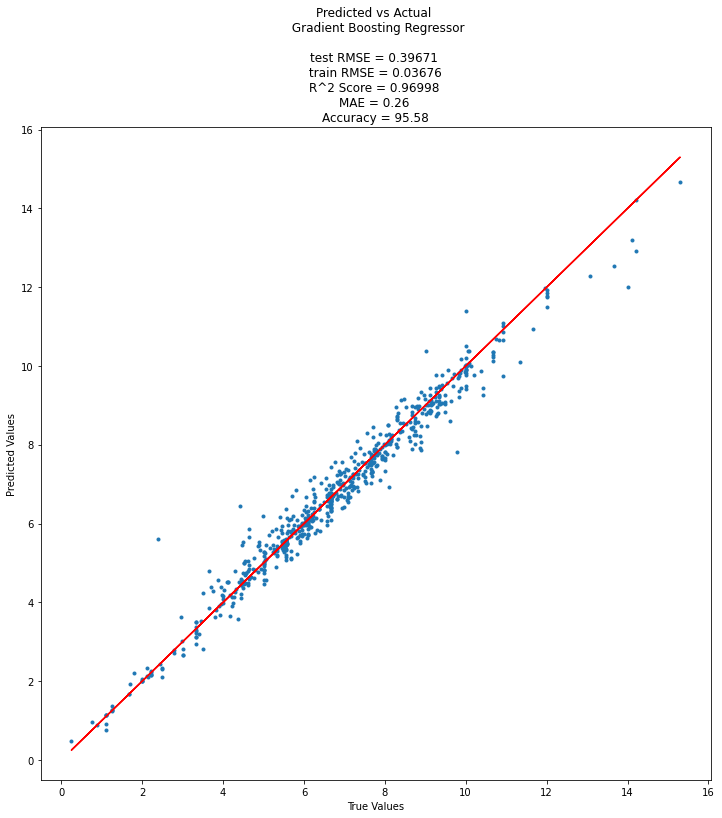

In [27]:
model = gb

y_pred = model.predict(X_test)
rsq = round(model.score(X_test, y_test), 5)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test ,y_pred)), 5)
y_train_pred = model.predict(X_train)
train_rmse = round(np.sqrt(metrics.mean_squared_error(y_train_pred ,y_train)), 5)

errors = abs(y_pred - y_test)
MAE = round(np.mean(errors), 2)
mape = np.mean(100 * (errors / y_test))
accuracy = round((100 - mape), 2)

stats = f"test RMSE = {test_rmse} \n " + \
          f"train RMSE = {train_rmse} \n" + \
          f"R^2 Score = {rsq} \n" + \
         f"MAE = {MAE} \n" + \
         f"Accuracy = {accuracy}" 

fig, ax = plt.subplots(figsize=(12,12))
ax.plot(y_test, y_test, 'r')
g=ax.scatter(y_test, y_pred, s = 9)
g.axes.set_xlabel('True Values')
g.axes.set_ylabel('Predicted Values')
g.axes.set_title('Predicted vs Actual \n Gradient Boosting Regressor\n \n' + stats)



The Gradient Boosting Regressor model seems to have a good predictive accuracy, with predictions reasonably close
to the actual value. The model undertands the data but cannot tell its story very well.

**XGBooster Regressor**

Text(0.5, 1.0, 'Predicted vs Actual \n XGBooster Regressor\n \ntest RMSE = 0.35301 \n train RMSE = 0.05385 \nR^2 Score = 0.97623 \nMAE = 0.23 \nAccuracy = 95.79')

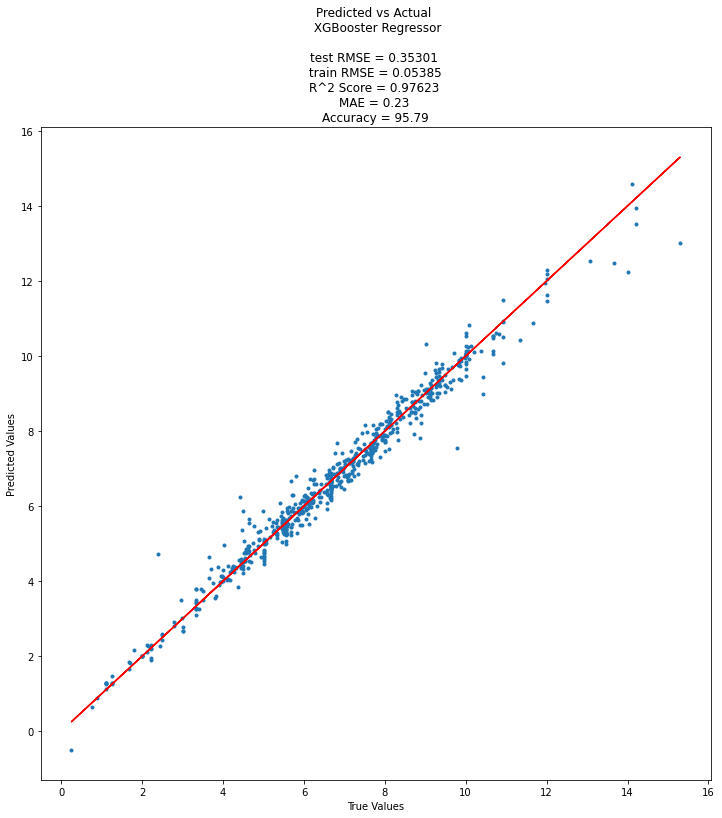

In [28]:
model = xgb

y_pred = model.predict(X_test)
rsq = round(model.score(X_test, y_test), 5)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test ,y_pred)), 5)
y_train_pred = model.predict(X_train)
train_rmse = round(np.sqrt(metrics.mean_squared_error(y_train_pred ,y_train)), 5)

errors = abs(y_pred - y_test)
MAE = round(np.mean(errors), 2)
mape = np.mean(100 * (errors / y_test))
accuracy = round((100 - mape), 2)


stats = f"test RMSE = {test_rmse} \n " + \
          f"train RMSE = {train_rmse} \n" + \
          f"R^2 Score = {rsq} \n" + \
         f"MAE = {MAE} \n" + \
         f"Accuracy = {accuracy}" 

fig, ax = plt.subplots(figsize=(12,12))
ax.plot(y_test, y_test, 'r')
g=ax.scatter(y_test, y_pred, s = 9)
g.axes.set_xlabel('True Values')
g.axes.set_ylabel('Predicted Values')
g.axes.set_title('Predicted vs Actual \n XGBooster Regressor\n \n' + stats)

The XGBooster Regressor model seems to have a rather good predictive accuracy, with predictions fairly close
to the actual value for most of the data points. The model undertands the data and can tell its story well.